## Employee Reviews da Microsoft 
### Objetivo:
Desenvolver um sistema que analisa avaliações de funcionários da Microsoft, processa os textos e classifica automaticamente cada review como positivo ou negativo, com base no conteúdo textual.

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

### Coleta e Organização dos Dados

In [2]:
#Importando e filtrando pra puxar somente os dados da Microsoft

import pandas as pd

df = pd.read_csv("employee_reviews.csv")

# Filtrando as avaliações da Microsoft
df = df[df['company'].str.lower() == 'microsoft'].reset_index(drop=True)

df.columns


Index(['Unnamed: 0', 'company', 'location', 'dates', 'job-title', 'summary',
       'pros', 'cons', 'advice-to-mgmt', 'overall-ratings',
       'work-balance-stars', 'culture-values-stars',
       'carrer-opportunities-stars', 'comp-benefit-stars',
       'senior-mangemnet-stars', 'helpful-count', 'link'],
      dtype='object')

### Pré-processamento de Texto

In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# 1. Criar coluna 'text'
df['text'] = df['pros'].fillna('') + ' ' + df['cons'].fillna('')

# 2. Verificar se 'text' foi criada corretamente
print(df[['pros', 'cons', 'text']].head())

stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(preprocess)


                                                pros  \
0  Culture, role impact, mission driven, collabor...   
1  1. If you love tech, this is a great place. No...   
2                     Great company and Great people   
3  Benefits, work-life balance, tons of internal ...   
4  Smart people, work life balance, growth mindse...   

                                                cons  \
0          Volume of work is sometimes unmanageable,   
1  Brand on Your Resume: After many years of losi...   
2                         I see no cons at this time   
3                       Can't think of any right now   
4                 Can be hard to transfer internally   

                                                text  
0  Culture, role impact, mission driven, collabor...  
1  1. If you love tech, this is a great place. No...  
2  Great company and Great people I see no cons a...  
3  Benefits, work-life balance, tons of internal ...  
4  Smart people, work life balance, growth mindse..

### Criação dos Rótulos (Positivo/Negativo)

In [4]:
# Rótulo binário: 1 = positivo (rating >= 4), 0 = negativo (rating <= 2)
df = df[df['overall-ratings'].isin([1.0, 2.0, 4.0, 5.0])]
df['label'] = df['overall-ratings'].apply(lambda x: 1 if x >= 4 else 0)


### Extração de Features

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(df['clean_text'])
y = df['label']

ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [6]:
def predict_sentiment(text, threshold=0.6):
    processed = preprocess(text)
    vectorized = vectorizer.transform([processed])
    prob = model.predict_proba(vectorized)[0][1]
    return int(prob >= threshold), prob

# Exemplo de teste
text = "I loved the leadership and career opportunities."
label, prob = predict_sentiment(text)
print(f"Label: {label}, Confidence: {prob:.2f}")


Label: 1, Confidence: 0.85


### Modelagem e Classificação

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Criação e treinamento do modelo
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Predição e avaliação
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.90      0.87      2417
           1       0.89      0.84      0.87      2449

    accuracy                           0.87      4866
   macro avg       0.87      0.87      0.87      4866
weighted avg       0.87      0.87      0.87      4866



### Simular Novos Reviews

In [8]:
def predict_review(text, threshold=0.5):
    clean = preprocess(text)
    print(f"Texto limpo: {clean}")

    vec = vectorizer.transform([clean])
    print(f"Vetorizado: {vec.toarray()}")

    prob = model.predict_proba(vec)[0][1]  # Probabilidade de ser classe 1
    print(f"Probabilidade da classe positiva: {prob:.4f}")

    prediction = 1 if prob >= threshold else 0
    print(f"Predição (com threshold={threshold}): {prediction}")

    return "Positivo" if prediction == 1 else "Negativo"

# Exemplo de uso
print(predict_review("The team is very collaborative, and the work-life balance is great."))
print()
print(predict_review("It is a bad place to work"))


Texto limpo: team collaborative worklife balance great
Vetorizado: [[0. 0. 0. ... 0. 0. 0.]]
Probabilidade da classe positiva: 0.9805
Predição (com threshold=0.5): 1
Positivo

Texto limpo: bad place work
Vetorizado: [[0. 0. 0. ... 0. 0. 0.]]
Probabilidade da classe positiva: 0.3889
Predição (com threshold=0.5): 0
Negativo


In [ ]:
#Salvando os documentos

import joblib

joblib.dump(model, "modelo_sentimento.pkl")
joblib.dump(vectorizer, "vetor_sentimento.pkl")
df.to_csv("modelo_tradicional.csv", index=False)


In [10]:
print(df.columns)


Index(['Unnamed: 0', 'company', 'location', 'dates', 'job-title', 'summary',
       'pros', 'cons', 'advice-to-mgmt', 'overall-ratings',
       'work-balance-stars', 'culture-values-stars',
       'carrer-opportunities-stars', 'comp-benefit-stars',
       'senior-mangemnet-stars', 'helpful-count', 'link', 'text', 'clean_text',
       'label'],
      dtype='object')


### Visualização e Interface

In [11]:
import gradio as gr
import joblib
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string



model = joblib.load("modelo_sentimento.pkl")
tfidf = joblib.load("vetorizador_tfidf.pkl")

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


def preprocess(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t not in string.punctuation]
    tokens = [t for t in tokens if t not in stopwords.words('english')]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)


def classificar_review(review_text):
    texto_limpo = preprocess(review_text)
    vetor = tfidf.transform([texto_limpo])
    pred = model.predict(vetor)[0]
    prob = model.predict_proba(vetor).max()
    return f"Sentimento: {'Positivo' if pred == 1 else 'Negativo'} (confiança: {prob:.2f})"

# Interface com Gradio
demo = gr.Interface(
    fn=classificar_review,
    inputs=gr.Textbox(lines=5, label="Digite um review da Microsoft"),
    outputs=gr.Textbox(label="Resultado da Classificação"),
    title="Classificador de Reviews - Microsoft",
    description="Este modelo classifica automaticamente se um review é positivo ou negativo com base em PLN."
)

if __name__ == "__main__":
    demo.launch()


c:\Users\rrs4_cesar\Desktop\Microsoft_Review\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rrs4_cesar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rrs4_cesar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rrs4_cesar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


## Modelo pré-treinado com Hugging Face

In [12]:
import pandas as pd
from transformers import pipeline
from tqdm import tqdm

# Carrega o dataset
df = pd.read_csv("employee_reviews.csv")

# Filtrando as avaliações da Microsoft
df = df[df['company'].str.lower() == 'microsoft'].reset_index(drop=True)

df.columns

# Junta pros e cons em uma coluna só se necessário
df['text'] = df['pros'].fillna('') + ' ' + df['cons'].fillna('')

# Carrega modelo de análise de sentimentos
sentiment_model = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Cria coluna de sentimentos com tqdm para mostrar progresso
tqdm.pandas()  # habilita barra de progresso

def classify_sentiment(text):
    result = sentiment_model(text[:512])[0]  # truncando se muito longo
    return result['label']

df['sentiment_huggingface'] = df['text'].progress_apply(classify_sentiment)

# Visualiza os primeiros resultados
print(df[['text', 'sentiment_huggingface']].head())

# (Opcional) salva como novo CSV
df.to_csv("modelo_huggingface.csv", index=False)


Device set to use cpu
100%|██████████| 17930/17930 [13:39<00:00, 21.89it/s]


                                                text sentiment_huggingface
0  Culture, role impact, mission driven, collabor...              NEGATIVE
1  1. If you love tech, this is a great place. No...              POSITIVE
2  Great company and Great people I see no cons a...              POSITIVE
3  Benefits, work-life balance, tons of internal ...              POSITIVE
4  Smart people, work life balance, growth mindse...              POSITIVE


### Exibindo os resultados:

In [13]:
# Exemplo de comentários positivos
print("\nExemplos de avaliações positivas:")
print(df[df['sentiment_huggingface'] == 'POSITIVE']['text'].head())

# Exemplo de comentários negativos
print("\nExemplos de avaliações negativas:")
print(df[df['sentiment_huggingface'] == 'NEGATIVE']['text'].head())



Exemplos de avaliações positivas:
1    1. If you love tech, this is a great place. No...
2    Great company and Great people I see no cons a...
3    Benefits, work-life balance, tons of internal ...
4    Smart people, work life balance, growth mindse...
5    Challenging work and collaboration with brilli...
Name: text, dtype: object

Exemplos de avaliações negativas:
0     Culture, role impact, mission driven, collabor...
17    Fantastic benefits, perks, and connections. Mi...
18    Clarity of work, growth, smart coworkers, bene...
20    Help people work safely in the field. Start ve...
22    Benefits for part time employees, education op...
Name: text, dtype: object


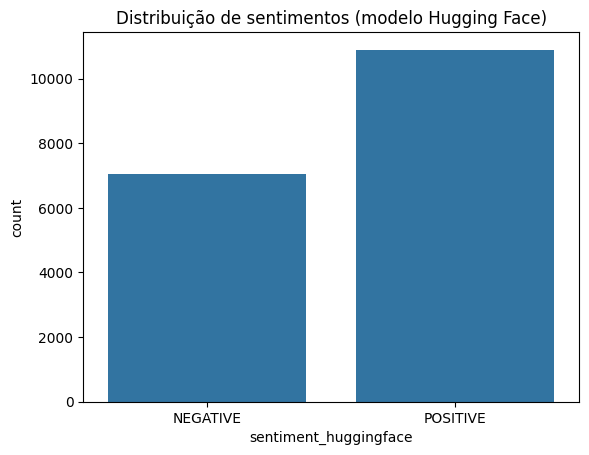

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='sentiment_huggingface')
plt.title("Distribuição de sentimentos (modelo Hugging Face)")
plt.show()


## Aplicar o modelo

In [17]:
import joblib

# Carrega os dados com sentimentos do Hugging Face
df = pd.read_csv("modelo_huggingface.csv")

# Carrega o modelo tradicional e o vetor
modelo = joblib.load("modelo_sentimento.pkl")
vetor = joblib.load("vetor_sentimento.pkl")

# Aplica o modelo tradicional
X_novo = vetor.transform(df['text'])
df['sentiment_tradicional'] = modelo.predict(X_novo)

# Salva com os dois sentimentos
df.to_csv("modelo_com_sentimentos.csv", index=False)

# Verifica
print(df[['text', 'sentiment_huggingface', 'sentiment_tradicional']].head())


                                                text sentiment_huggingface  \
0  Culture, role impact, mission driven, collabor...              NEGATIVE   
1  1. If you love tech, this is a great place. No...              POSITIVE   
2  Great company and Great people I see no cons a...              POSITIVE   
3  Benefits, work-life balance, tons of internal ...              POSITIVE   
4  Smart people, work life balance, growth mindse...              POSITIVE   

   sentiment_tradicional  
0                      1  
1                      0  
2                      1  
3                      1  
4                      1  


## COMPARAÇÃO ENTRE OS MODELOS:

In [28]:
#padronizando os modelos

df['sentiment_tradicional'] = df['sentiment_tradicional'].astype(str).str.lower()
df['sentiment_huggingface'] = df['sentiment_huggingface'].astype(str).str.lower()
# Mapeia '1' para 'positive' e '0' para 'negative'
df['sentiment_tradicional'] = df['sentiment_tradicional'].map({'1': 'positive', '0': 'negative'})




In [29]:
# Compara se as classificações foram iguais
df['concordam'] = df['sentiment_huggingface'] == df['sentiment_tradicional']

# Percentual de concordância
concordancia = df['concordam'].mean() * 100
print(f"Os modelos concordam em {concordancia:.2f}% dos casos.")

# Contagem absoluta
print(df['concordam'].value_counts())


Os modelos concordam em 64.93% dos casos.
concordam
True     11642
False     6288
Name: count, dtype: int64


In [32]:
# Tabela cruzada
tabela = pd.crosstab(df['sentiment_huggingface'], df['sentiment_tradicional'])
print(tabela)


sentiment_tradicional  negative  positive
sentiment_huggingface                    
negative                   2843      4189
positive                   2099      8799


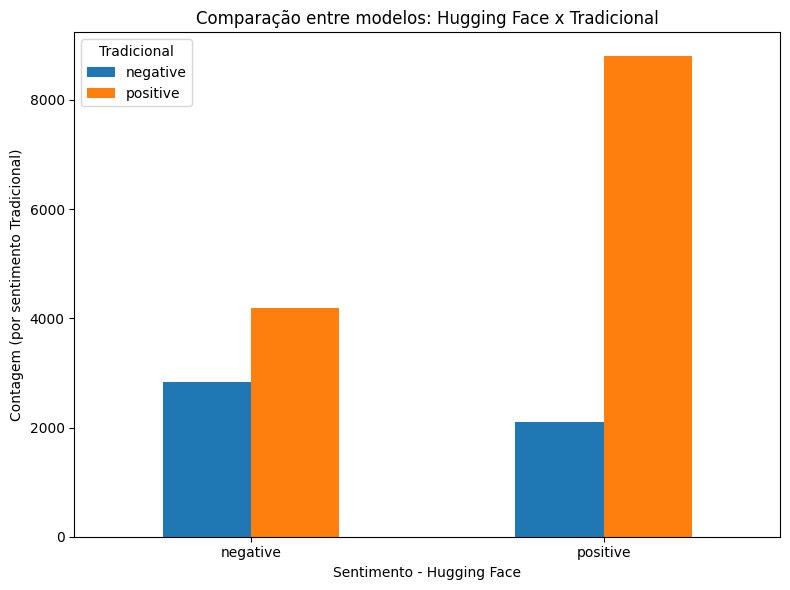

In [33]:

tabela.plot(kind='bar', figsize=(8, 6))
plt.title('Comparação entre modelos: Hugging Face x Tradicional')
plt.xlabel('Sentimento - Hugging Face')
plt.ylabel('Contagem (por sentimento Tradicional)')
plt.xticks(rotation=0)
plt.legend(title='Tradicional')
plt.tight_layout()
plt.show()


In [34]:
# Mostra os 5 primeiros casos de discordância
discordantes = df[df['sentiment_huggingface'] != df['sentiment_tradicional']]
print(discordantes[['text', 'sentiment_huggingface', 'sentiment_tradicional']].head())


                                                 text sentiment_huggingface  \
0   Culture, role impact, mission driven, collabor...              negative   
1   1. If you love tech, this is a great place. No...              positive   
5   Challenging work and collaboration with brilli...              positive   
18  Clarity of work, growth, smart coworkers, bene...              negative   
20  Help people work safely in the field. Start ve...              negative   

   sentiment_tradicional  
0               positive  
1               negative  
5               negative  
18              positive  
20              positive  
